<a href="https://colab.research.google.com/github/auroramugnai/Minimum-Exact-Cover-Problem/blob/main/MECP_with-QAOA/QAOA_random_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the MECP with QAOA+ using "Random Parameters" technique

In [6]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/auroramugnai/Minimum-Exact-Cover-Problem.git
%cd Minimum-Exact-Cover-Problem/MECP_with-QAOA
!pip install -r requirements.txt

fatal: destination path 'Minimum-Exact-Cover-Problem' already exists and is not an empty directory.
/content/Minimum-Exact-Cover-Problem/MECP_with-QAOA
 gaps.ipynb
 k_analysis.ipynb
 multiple_barplot.ipynb
'parameter_fixing_2025-01-30@10h22m24s'/
 QAOA_parameter_fixing.ipynb
 QAOA_random_parameters.ipynb
 random_instances.py
'random_parameters_2025-01-30@09h03m50s'/
'random_parameters_2025-06-09@16h44m34s'/
'random_parameters_2025-06-09@16h52m58s'/
'random_parameters_2025-06-09@16h57m20s'/
'random_parameters_2025-06-12@10h20m27s'/
'random_parameters_2025-06-20@11h14m30s'/
'random_parameters_2025-06-20@12h00m17s'/
'random_parameters_2025-06-20@13h48m29s'/
'random_parameters_2025-06-20@14h52m53s'/
'random_parameters_2025-06-20@16h32m58s'/
'random_parameters_2025-06-20@17h27m36s'/
'random_parameters_2025-06-20@18h33m26s'/
'random_parameters_2025-07-21@17h20m50s'/
'random_parameters_2025-07-22@15h10m16s'/
'random_parameters_2025-07-23@10h37m20s'/
 README.md
 requirements.txt
 utils_for_plo

## Import Modules & Define Functions

In [1]:
from __future__ import annotations
from utils_to_build_QAOAAnsatz import *


# Choose the data.
from random_instances import info_dim6
# from Wang_instances import info_dim6

In [2]:
from datetime import datetime
import math
import random
import time

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
from pprint import pprint # to print dictionaries

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
def write_params_on_file(DATA_FILE, params):

    DATA_FILE.write("\nChosen parameters:\n")
    DATA_FILE.write(f"Number of layers (p): {params['p']}\n")
    DATA_FILE.write(f"Number of random attempts: {params['random_attempts']}\n")
    DATA_FILE.write(f"Initialization type: {params['init_string']}\n")
    DATA_FILE.write(f"Size (n): {params['n']}\n")
    DATA_FILE.write(f"Chosen instances (chosen_instances): {params['chosen_instances']}\n")
    DATA_FILE.write(f"Choices of k (chosen_ks): {params['chosen_ks']}\n")


    # Display the chosen parameters
    print(f"######### ...Writing on file...: #########")
    print("Chosen parameters:")
    print(f"Number of layers (p): {params['p']}")
    print(f"Number of random attempts: {params['random_attempts']}")
    print(f"Initialization type: {params['init_string']}")
    print(f"Size (n): {params['n']}")
    print(f"Chosen instances (chosen_instances): {params['chosen_instances']}")
    print(f"Choice of ks (chosen_ks): {params['chosen_ks']}")
    print(f"##########################################")

def compute_L_EC(info_dim6):
    """ For each instance, compute the number of ones in each exact cover string
    that is not the mec string."""
    L_ECs = {}
    for key in info_dim6:
        if key != 'U':
            ec_strings = info_dim6[key]['exact_covers']
            mec_string = info_dim6[key]['mec']
            for ec in ec_strings:
                if ec != mec_string:
                    L_ECs[key] = ec.count('1')
    print("L_ECs:", L_ECs)
    return L_ECs

def compute_L_MEC(info_dim6):
    """ For each instance, compute the number of ones in the mec string."""
    L_MECs = []
    for key in info_dim6:
        if key != 'U':
            mec_string = info_dim6[key]['mec']
            L_MECs.append(mec_string.count('1'))
    print("L_MECs:", L_MECs)
    return L_MECs

def compute_L_from_k(info_dim6, k):
    """ Compute L from k, where k is a parameter that we choose.
    k = L/(min_length * n) so L = k * min_length * n
    where min_length is the minimum number of elements in a subset of an instance
    and n is the number of subsets in the instance.
    Parameters
    ----------
    k : float
        The parameter k.
    info_dim6 : dict
        The dictionary containing the instances information.
    Returns
    -------
    Ls : list
        A list of L values computed from k for each instance.
    """
    n = 6
    Ls = []
    for instance in info_dim6.keys():
        if instance == 'U':
            continue
        min_length = min(len(s) for s in info_dim6[instance]['subsets'])
        Ls.append(int(k * min_length * n))

    print(f"Ls from k={k}:", Ls)

In [5]:
import pprint
pprint.pprint(info_dim6)
compute_L_EC(info_dim6)
compute_L_MEC(info_dim6)
compute_L_from_k(info_dim6, 1)

{1: {'exact_covers': ['010101', '001100'],
     'mec': '001100',
     'subsets': [{1, 3, 4, 5, 6, 7, 8, 9, 11, 12},
                 {2, 11, 4, 5},
                 {1, 2, 4, 5, 6, 11},
                 {3, 7, 8, 9, 10, 12},
                 {2, 3, 4, 6, 7, 8, 9, 10, 11, 12},
                 {1, 6}]},
 2: {'exact_covers': ['101110', '100011'],
     'mec': '100011',
     'subsets': [{8, 9, 11},
                 {2, 4, 5, 6, 7, 8, 9, 10, 11, 12},
                 {1, 10, 12, 7},
                 {2, 3},
                 {4, 5, 6},
                 {1, 2, 3, 7, 10, 12}]},
 3: {'exact_covers': ['001111', '101001'],
     'mec': '101001',
     'subsets': [{2, 10, 4, 5},
                 {1, 3, 4, 5, 6, 7, 9, 10, 11, 12},
                 {3, 7, 8, 9, 11, 12},
                 {2, 10},
                 {4, 5},
                 {1, 6}]},
 4: {'exact_covers': ['110001', '001001'],
     'mec': '001001',
     'subsets': [{3, 4, 12, 7},
                 {5, 6},
                 {3, 4, 5, 6, 7, 12

## Set Parameters

In [6]:
### Get parameters from the user
params = get_parameters_from_user()

# Get the parameters separately
chosen_instances = params['chosen_instances']
chosen_ks = params['chosen_ks']
p = params['p']
random_attempts = params['random_attempts']
init_string = params['init_string']

n = params['n']

Number of layers (p), default is 4:  3
Number of random attempts, default is 50:  100
String initialization (all1 or all0), default is all0:  
Size n (6, 8, 10), default is 6:  
Chosen instances, default is [1, ..., 10] (Give a list please!):  
Choice for L, to compute k as L/(min_length * n). Give a list specifying L for every instance chosen please. [12, 12, 12, 12, 12, 18, 12, 18, 12, 18]


## For Every Instance Chosen, Do the Minimization
This code iterates through selected instances, generating corresponding subsets and computing the spectrum of states, including Minimum Exact Cover (MEC) states. It then builds the quantum circuits for the QAOA+ algorithm, including cost, mixing, and initialization circuits. Initial angles (betas and gammas) are randomly set within specified bounds, and the QAOA+ algorithm is run for multiple random initializations to minimize energy. Results, such as the optimal parameters, best attempt, minimum energy, and elapsed time, are recorded. Final data of each instance is saved in a .csv and a .txt.



Saving in folder_path = 'random_parameters_2025-09-16@20h20m11s'
**************************************************
Instance 1 with h = 1.0



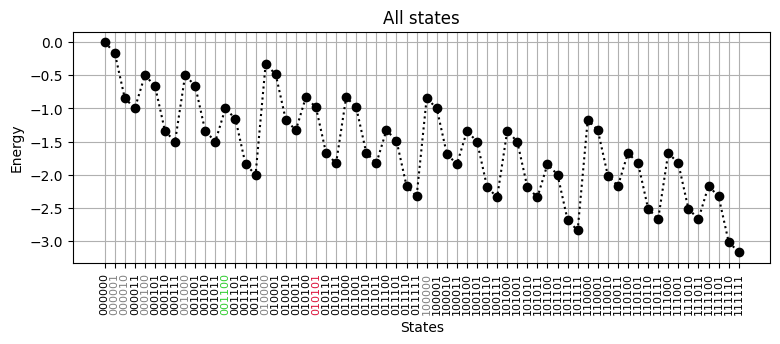

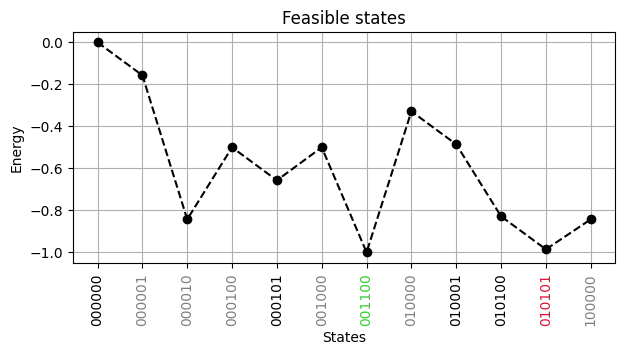

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758046811.782495
---------- 100/100 random_attempts -----------

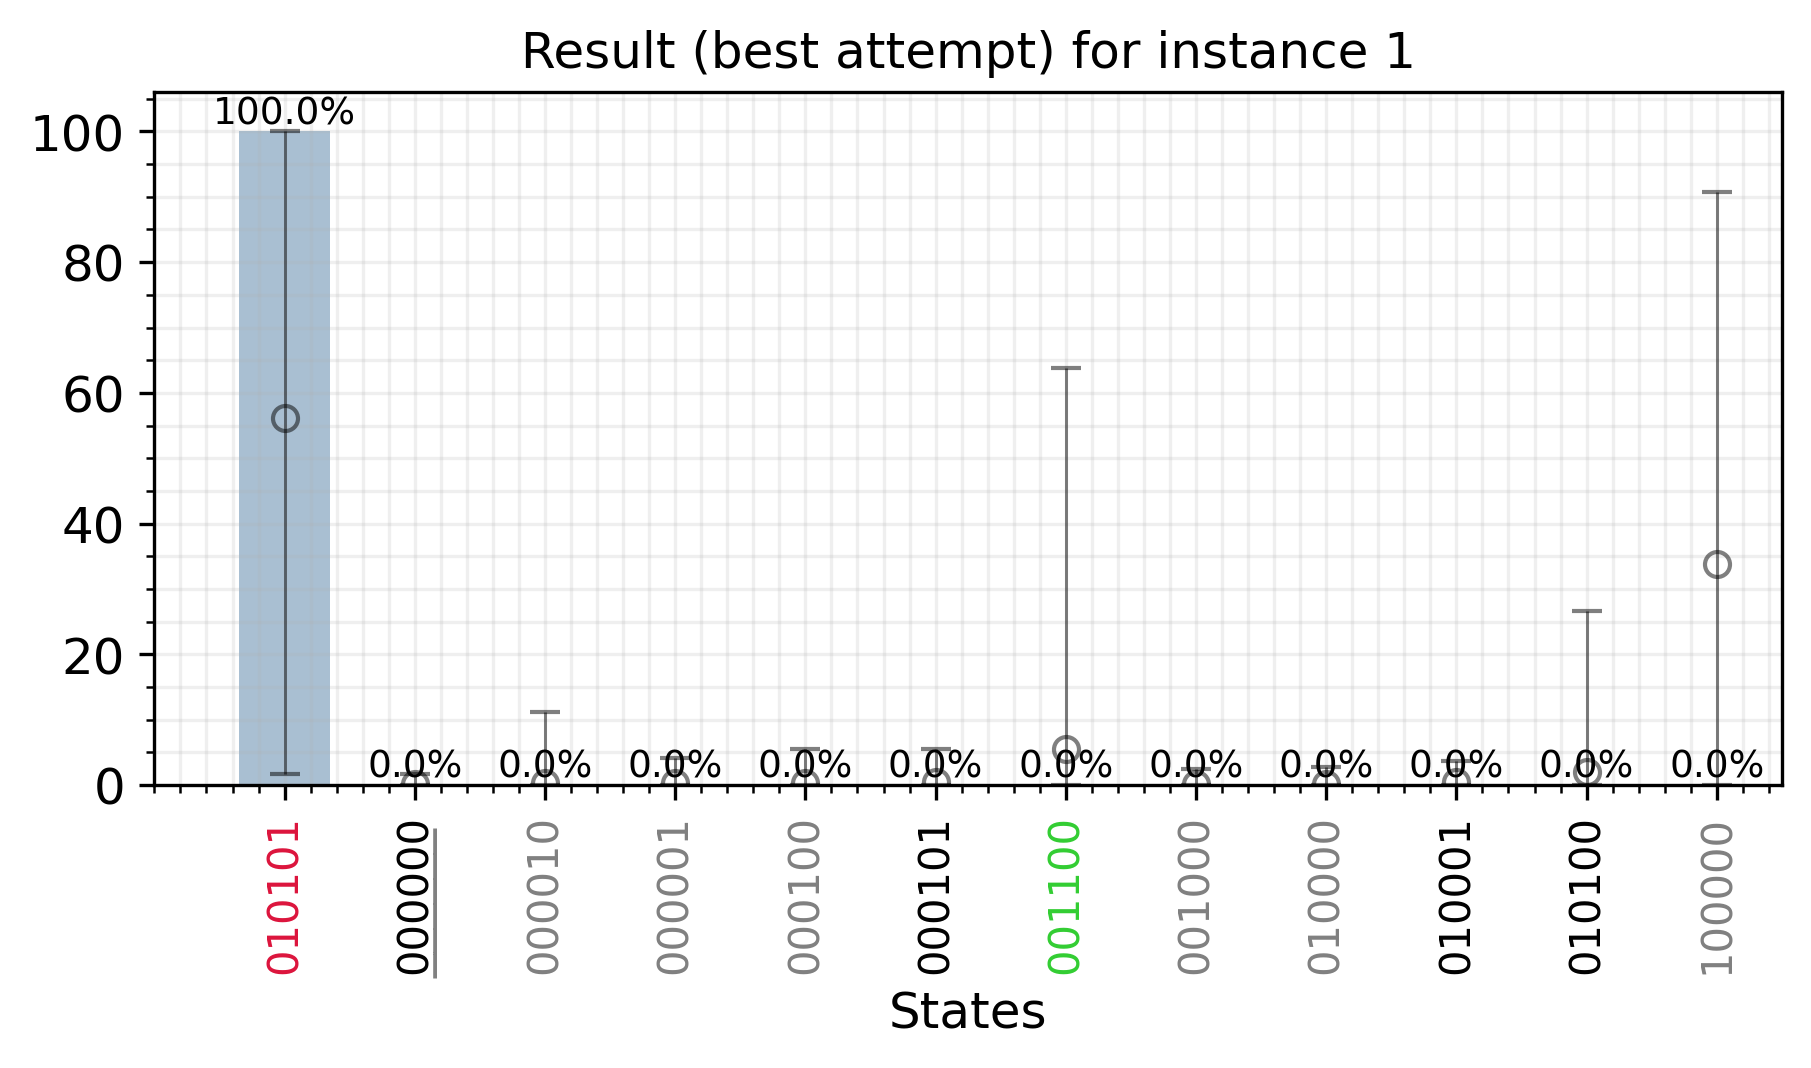

TOTAL_end_time =  1758047888.590436
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail1_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail1_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 17.94680016040802 minutes.
**************************************************
Instance 2 with h = 1.0



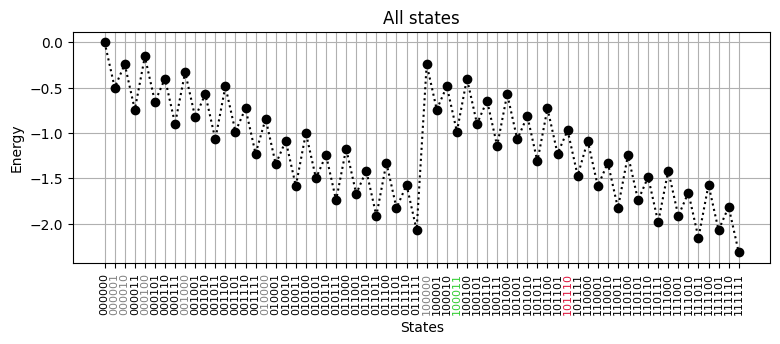

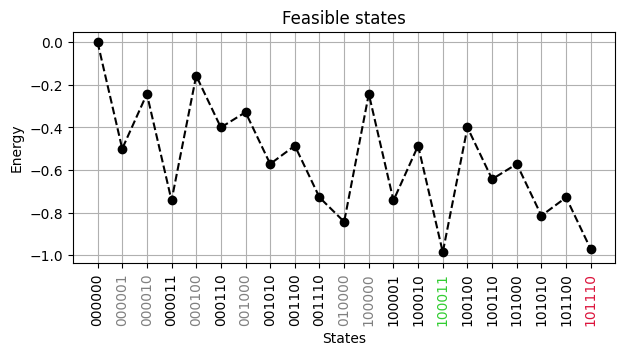

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758047888.9003265
---------- 100/100 random_attempts -----------

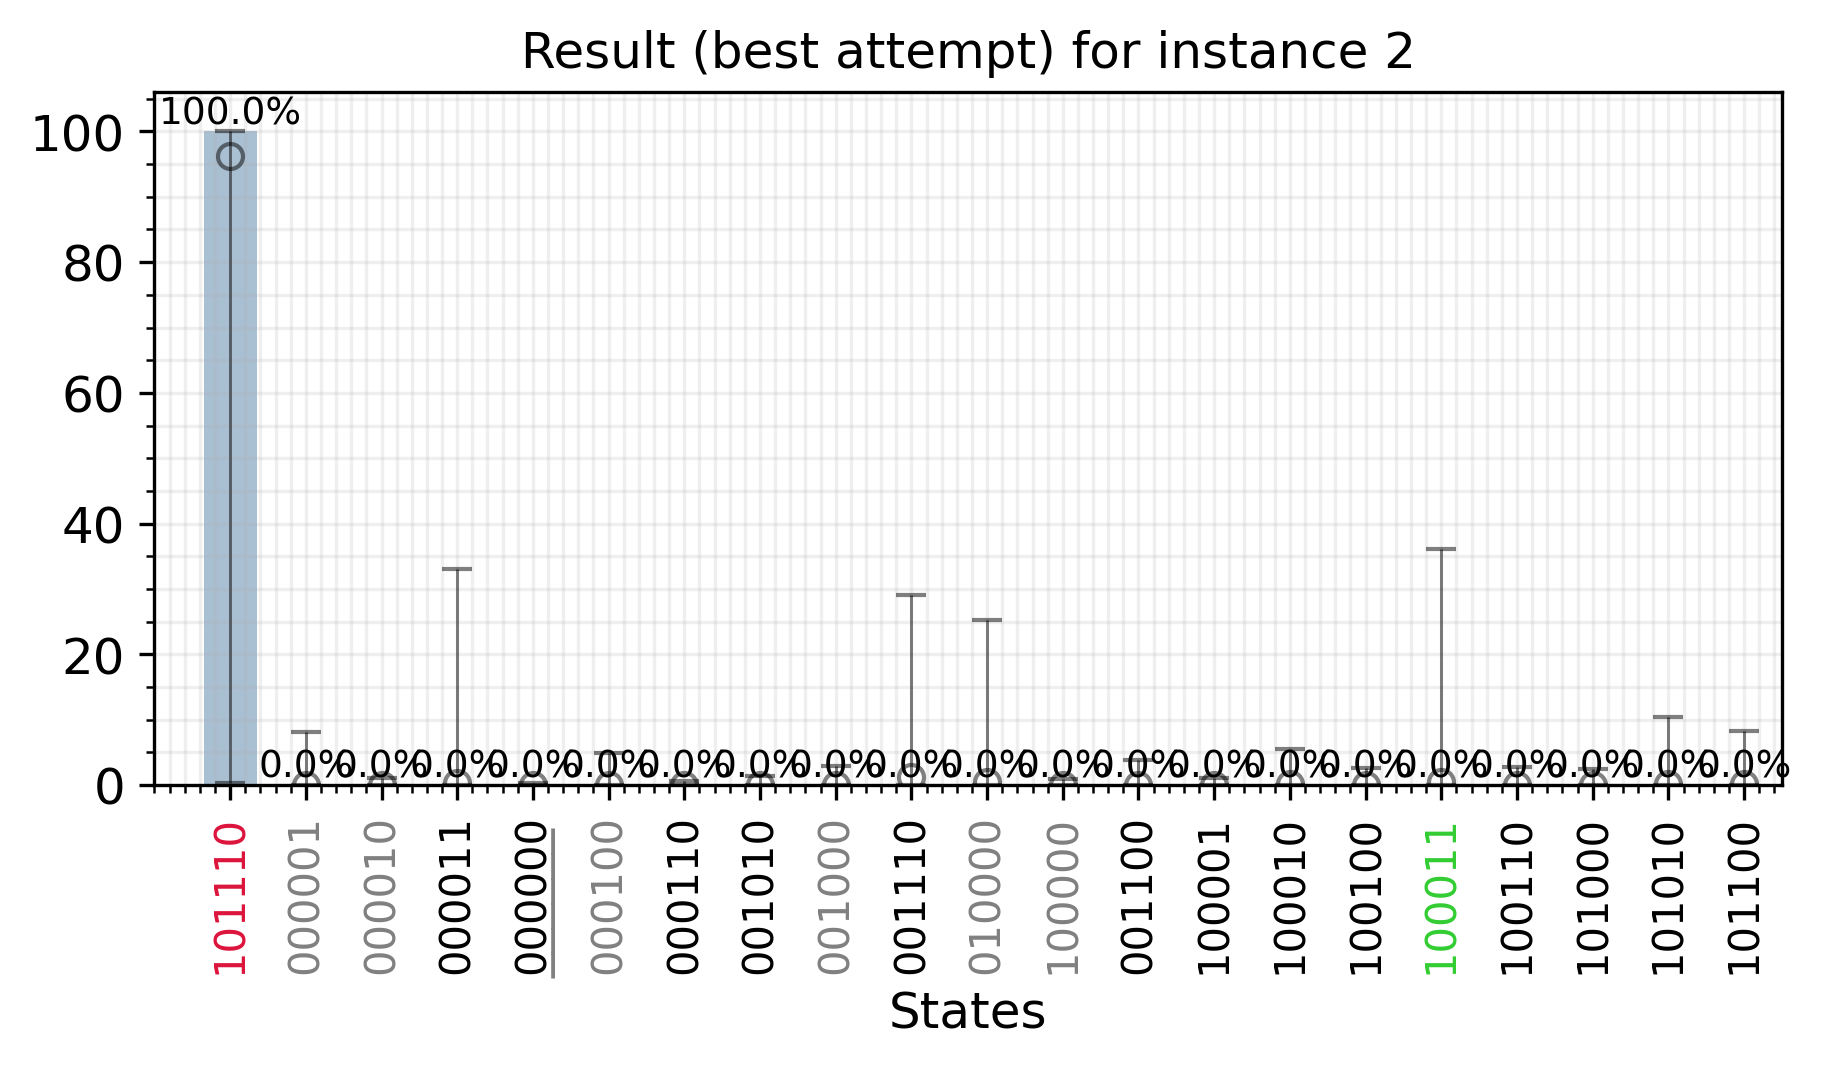

TOTAL_end_time =  1758048535.3664048
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail2_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail2_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 10.774435643355051 minutes.
**************************************************
Instance 3 with h = 1.0



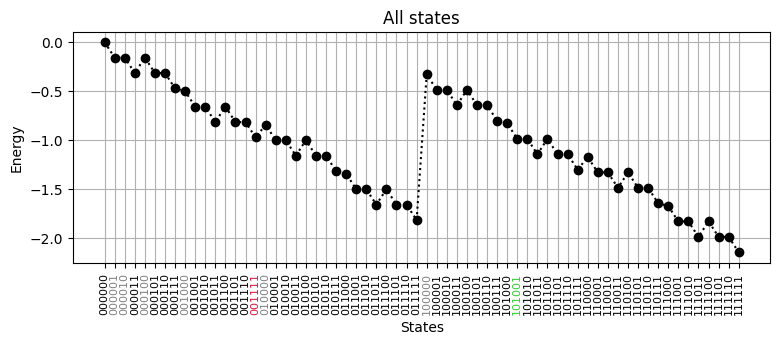

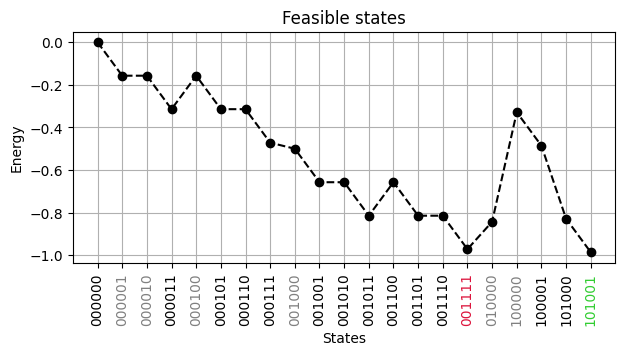

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758048536.195594
---------- 100/100 random_attempts -----------

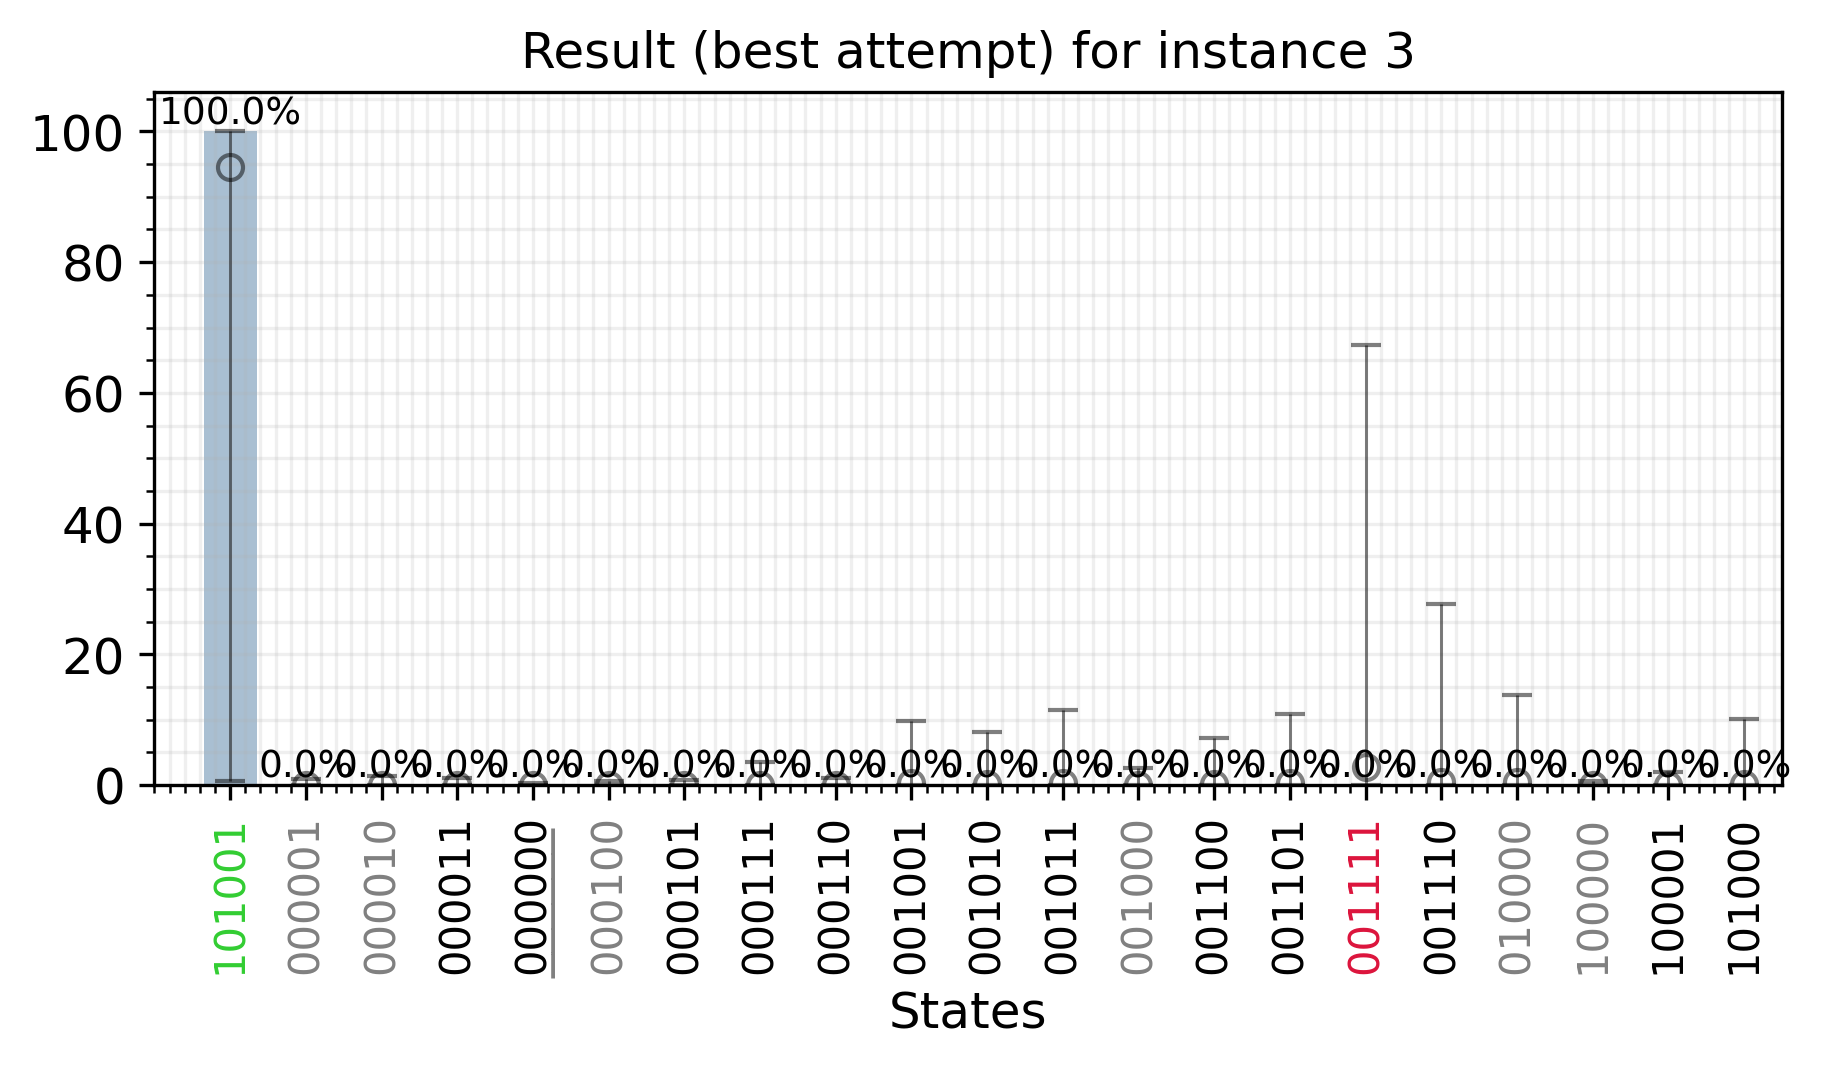

TOTAL_end_time =  1758049286.967968
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail3_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail3_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 12.512874007225037 minutes.
**************************************************
Instance 4 with h = 1.0



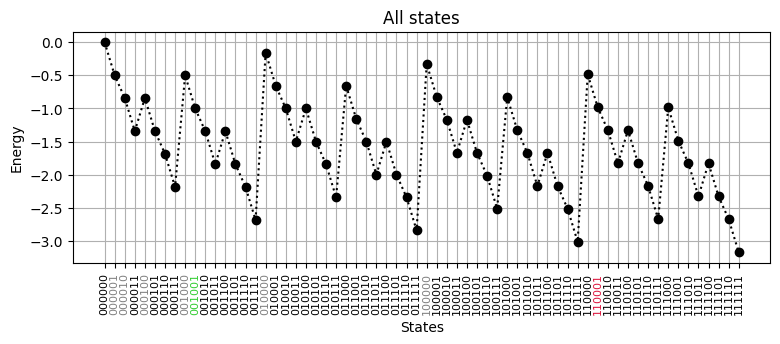

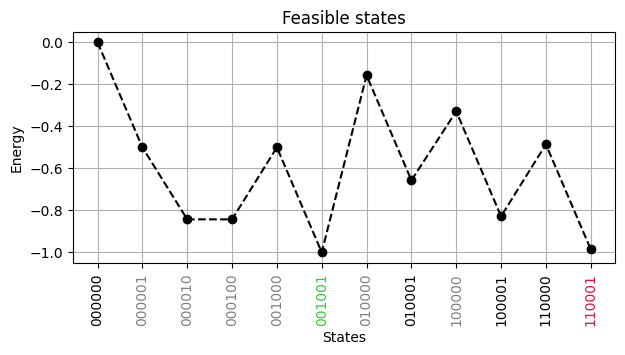

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758049287.2464776
---------- 100/100 random_attempts -----------

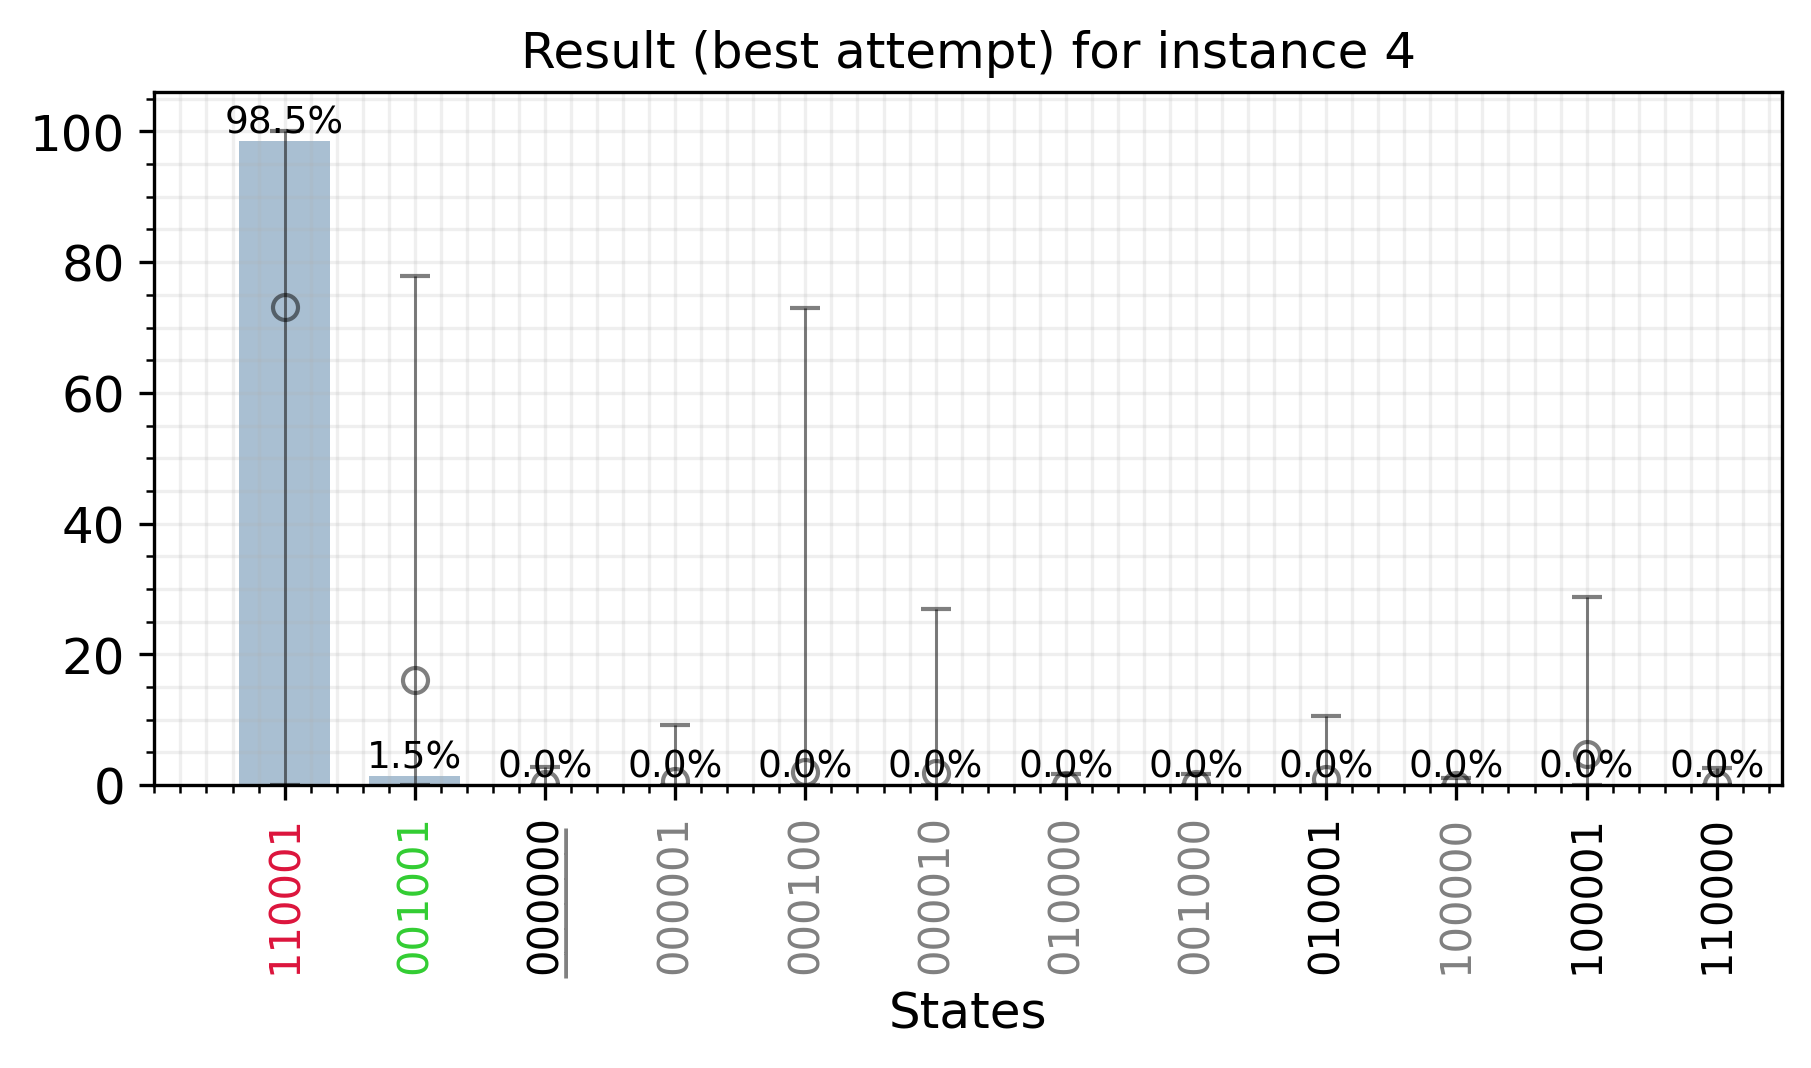

TOTAL_end_time =  1758050409.2527745
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail4_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail4_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 18.70010592540105 minutes.
**************************************************
Instance 5 with h = 1.0



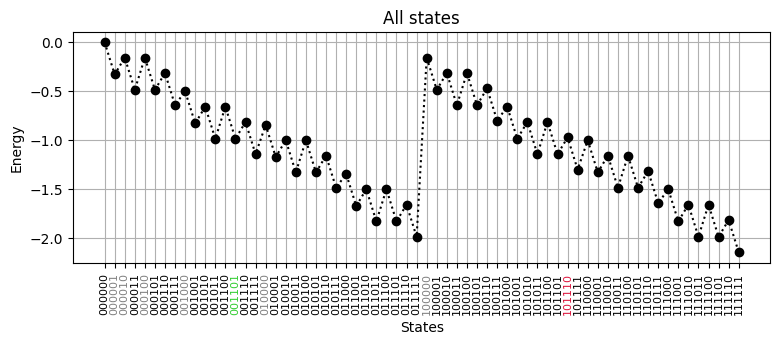

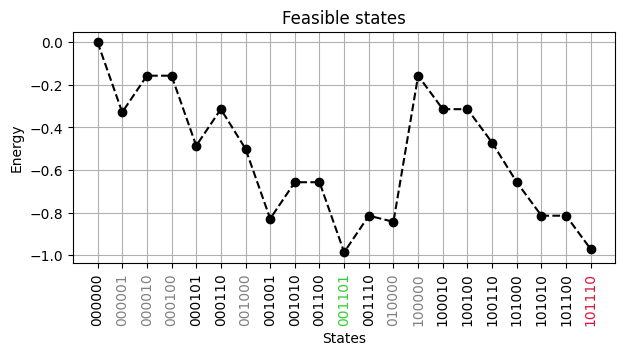

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758050409.626165
---------- 100/100 random_attempts -----------

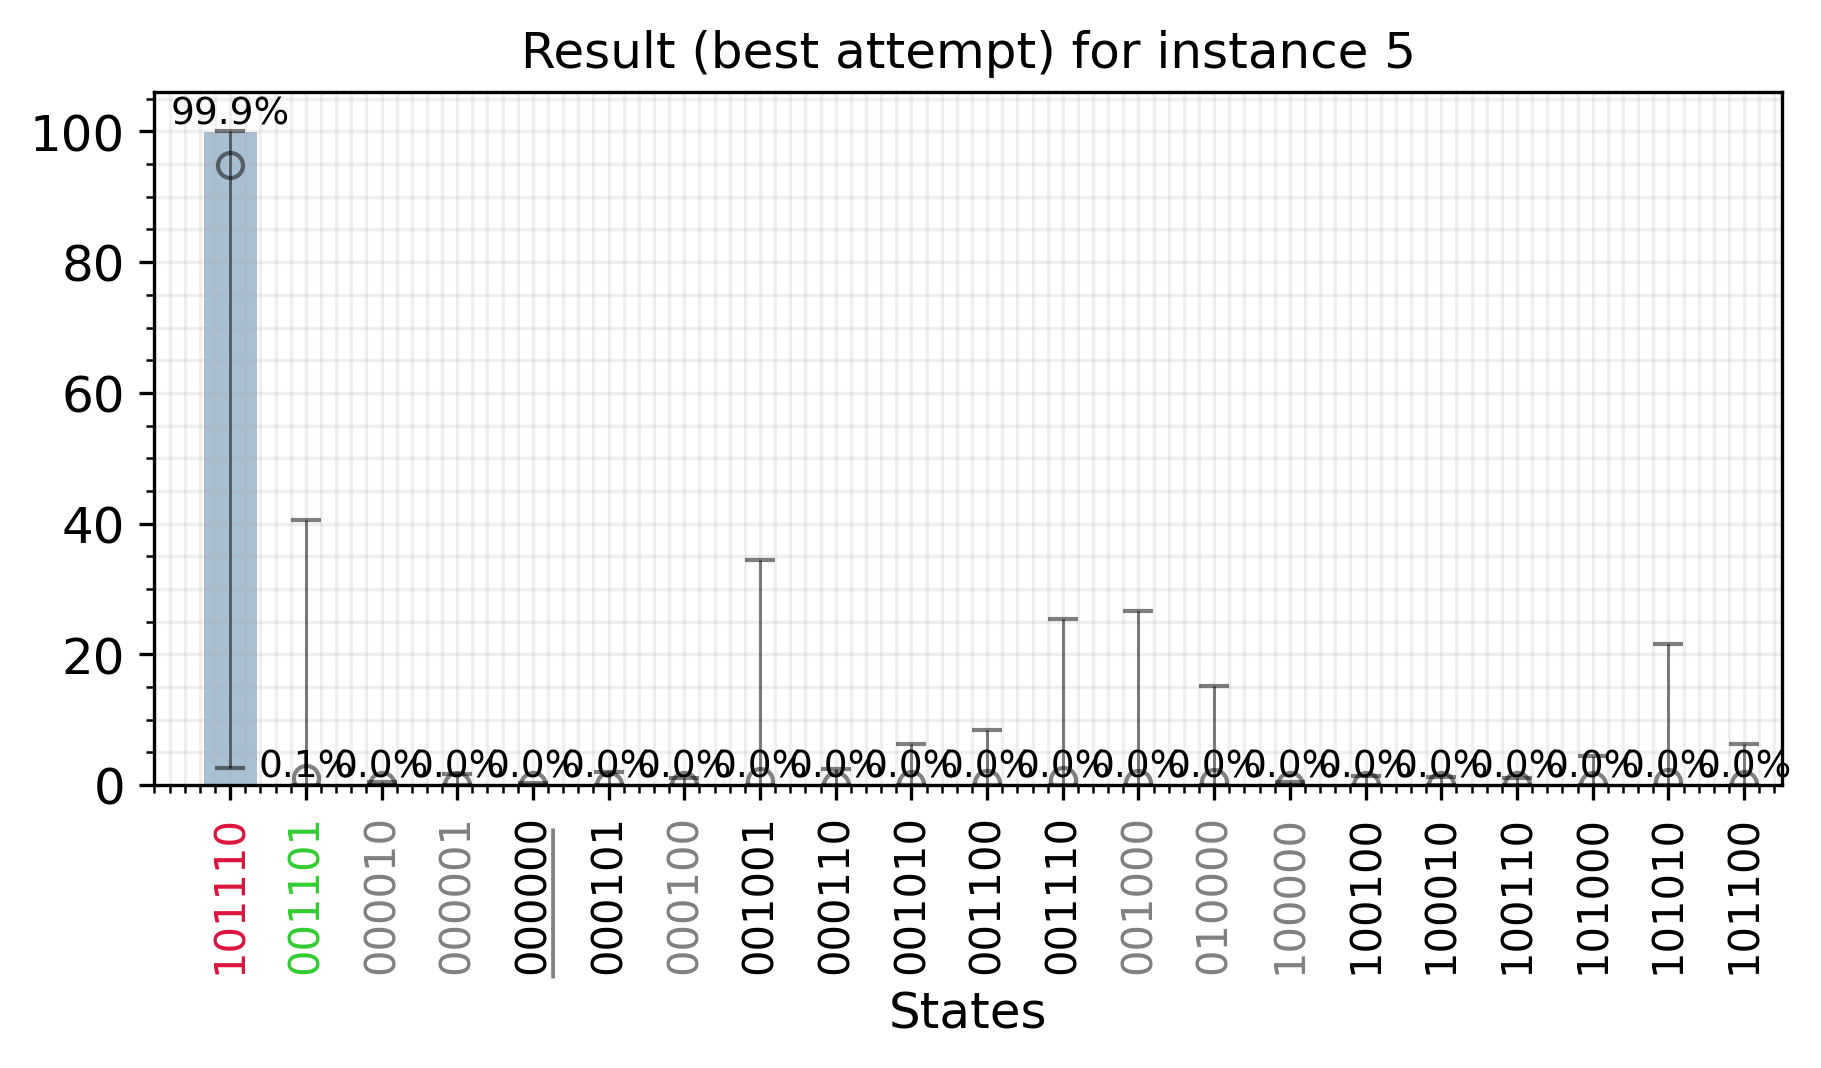

TOTAL_end_time =  1758051485.5537968
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail5_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail5_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 17.932128179073334 minutes.
**************************************************
Instance 6 with h = 1.0



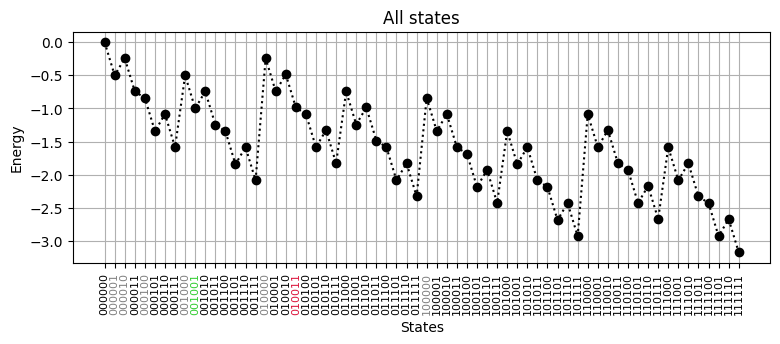

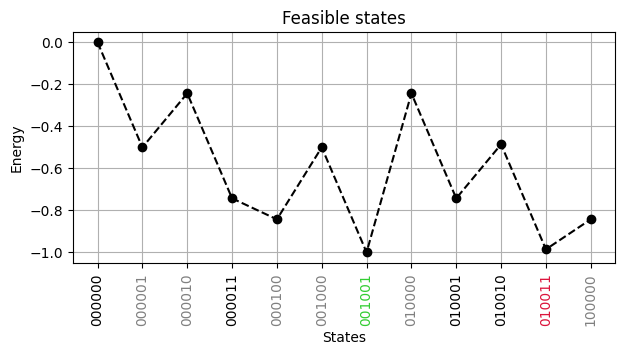

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758051485.8023355
---------- 100/100 random_attempts -----------

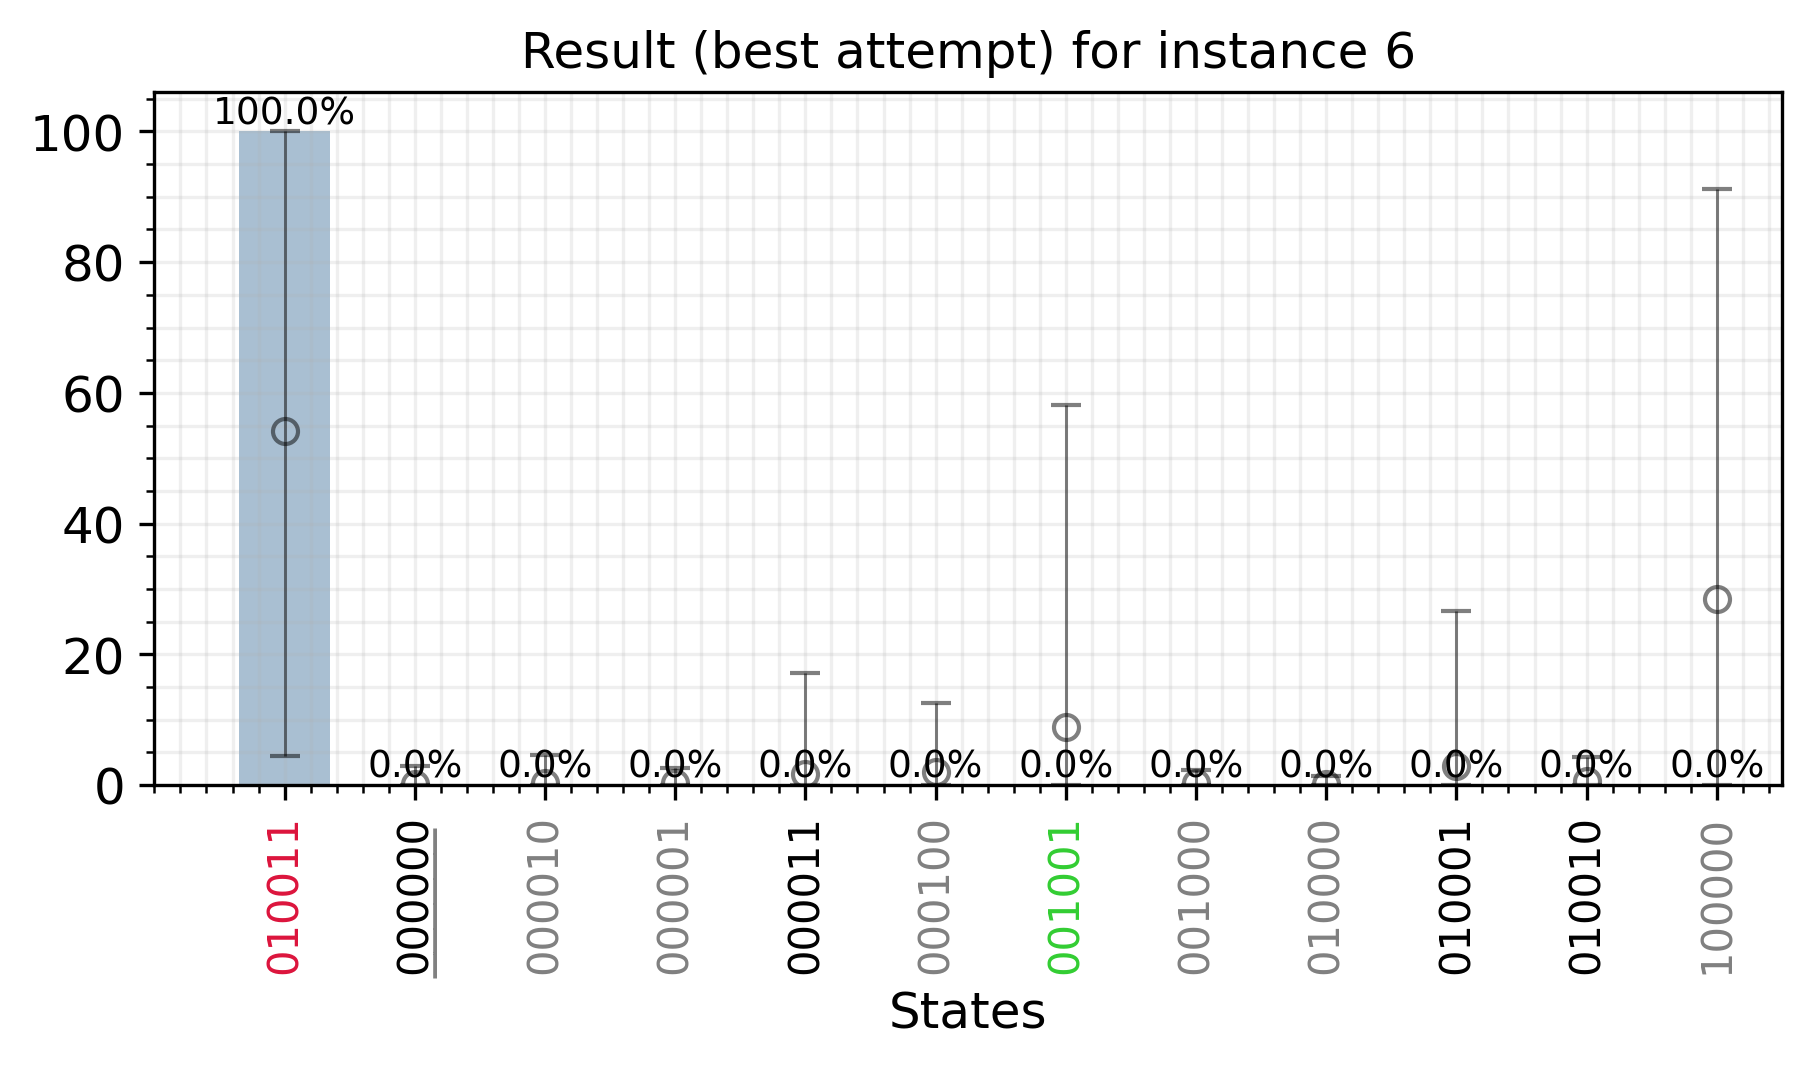

TOTAL_end_time =  1758052394.1196313
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail6_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail6_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781]_data.txt

TOTAL ELAPSED TIME: 15.138622955481212 minutes.
**************************************************
Instance 7 with h = 1.0



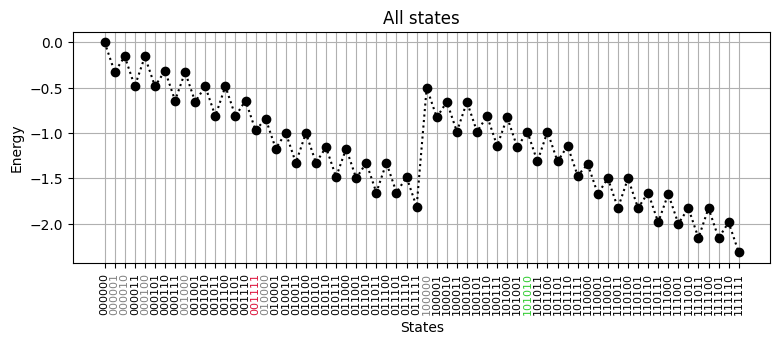

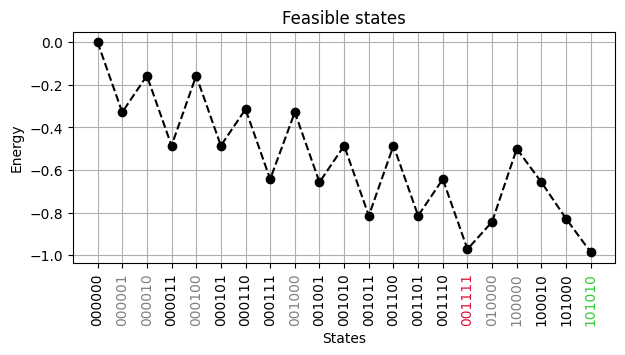

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758052394.3802283
---------- 100/100 random_attempts -----------

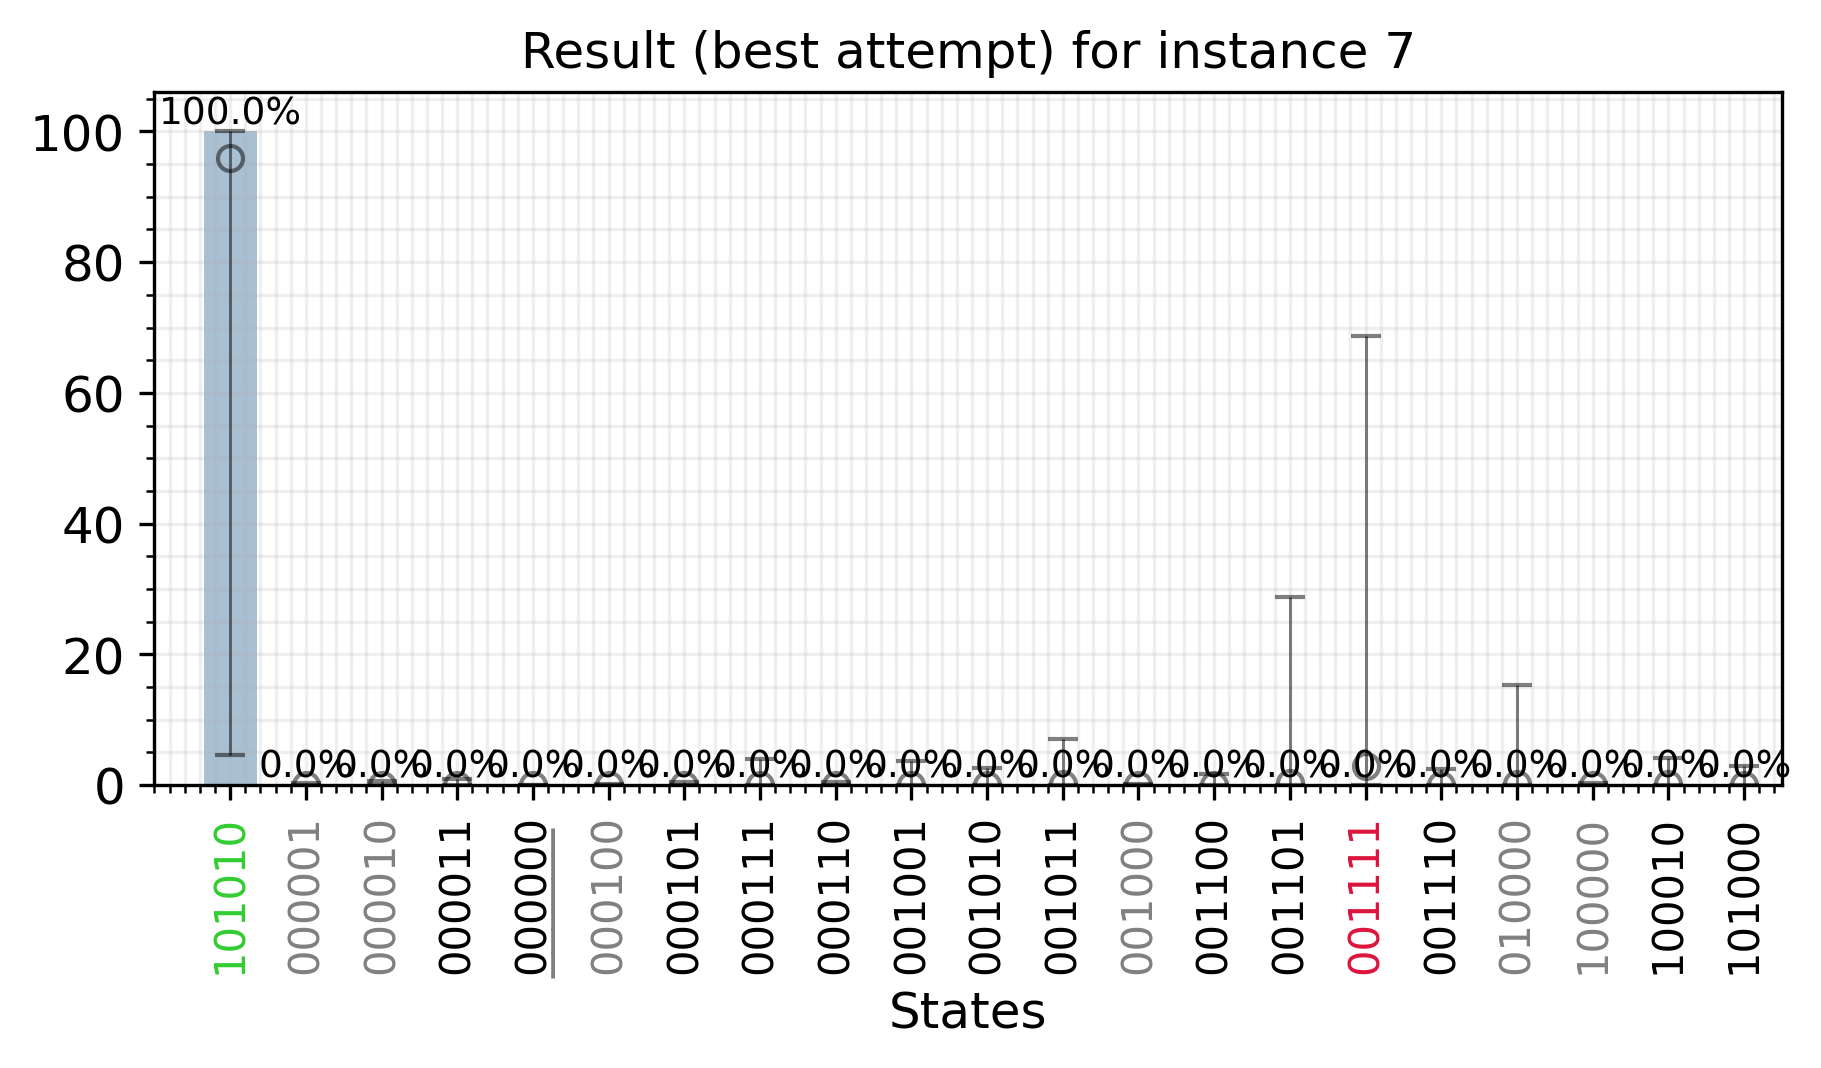

TOTAL_end_time =  1758052972.5215902
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail7_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail7_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 9.635690299669902 minutes.
**************************************************
Instance 8 with h = 1.0



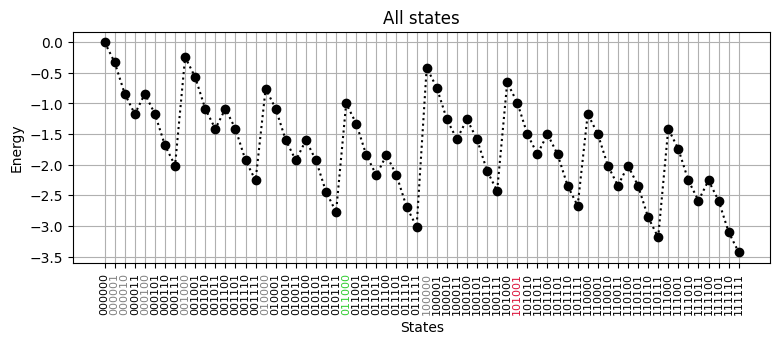

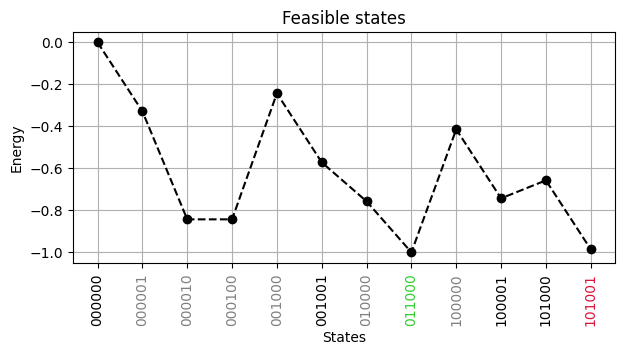

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758052972.7729669
---------- 100/100 random_attempts -----------

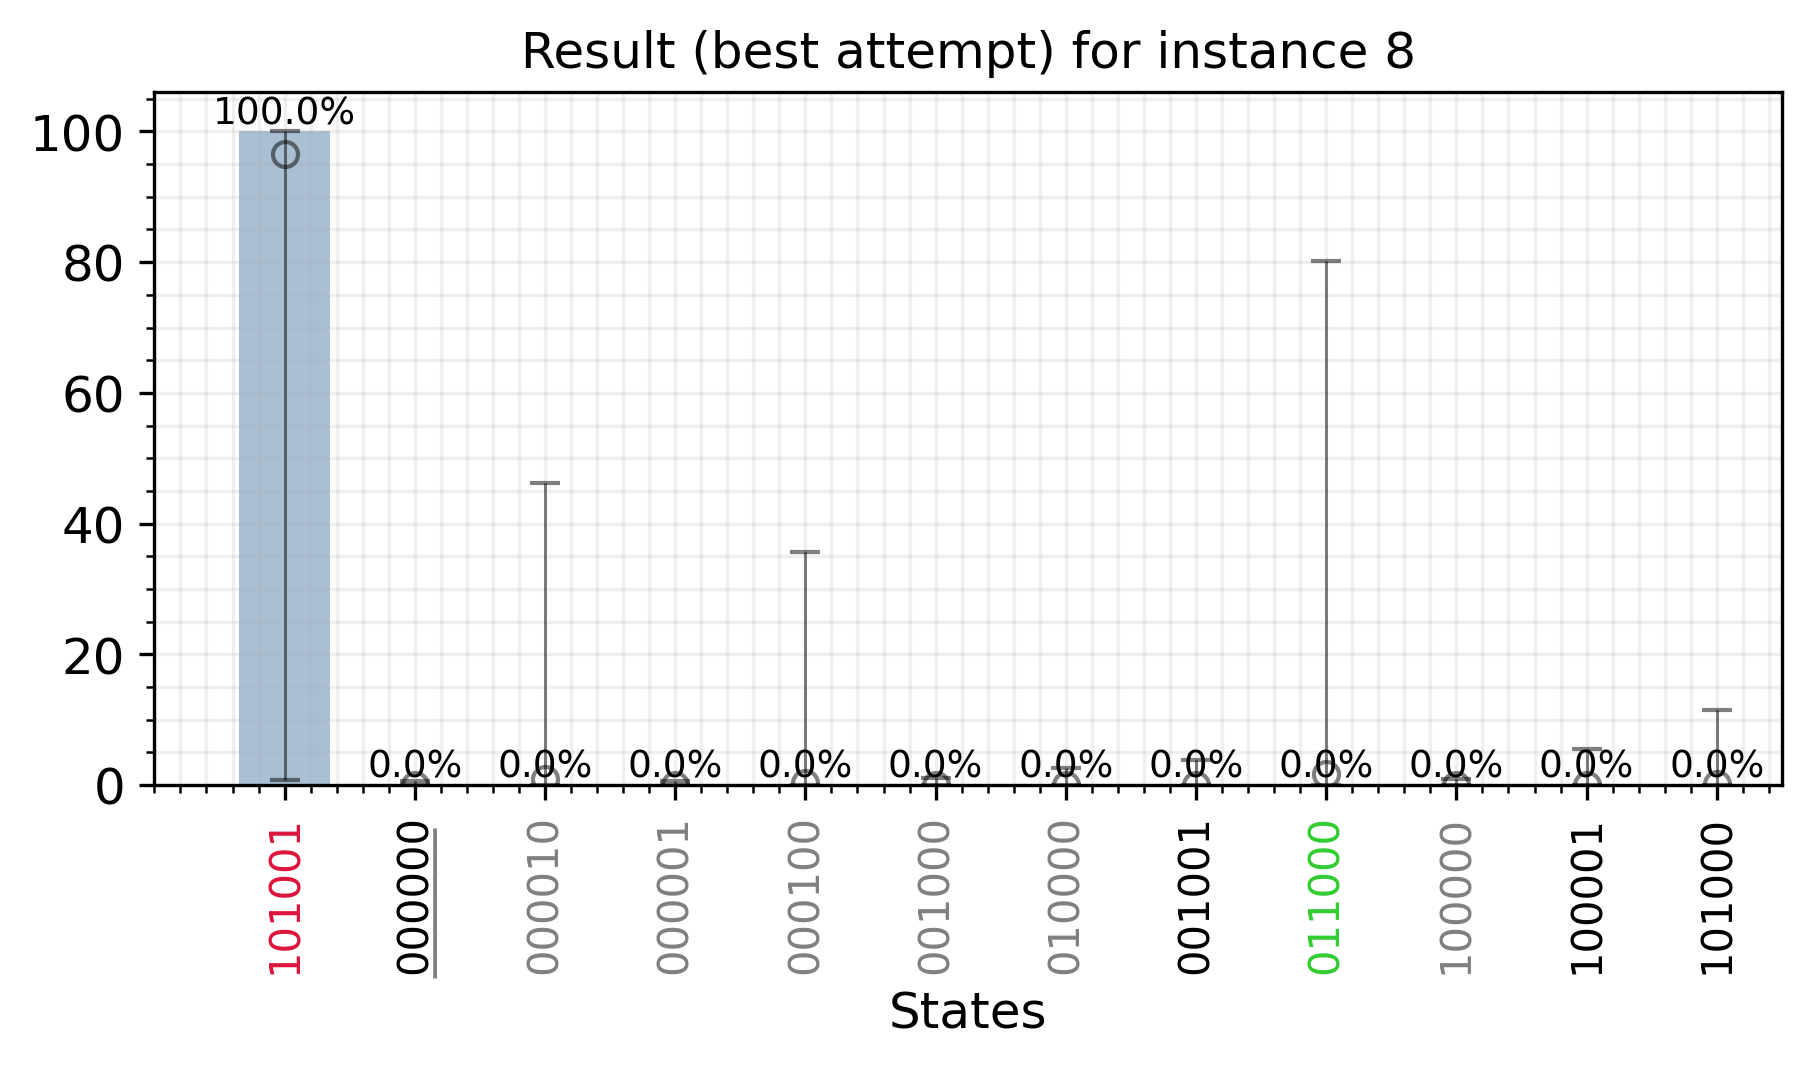

TOTAL_end_time =  1758053759.3721797
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail8_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail8_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781]_data.txt

TOTAL ELAPSED TIME: 13.109989484151205 minutes.
**************************************************
Instance 9 with h = 1.0



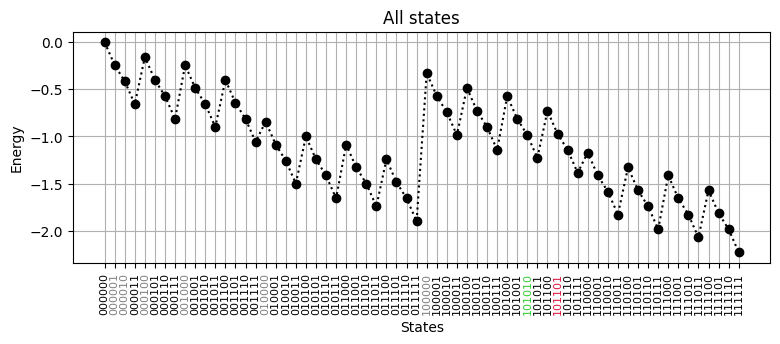

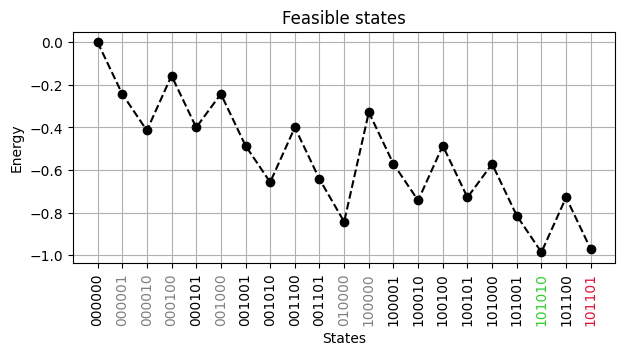

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758053759.679148
---------- 100/100 random_attempts -----------

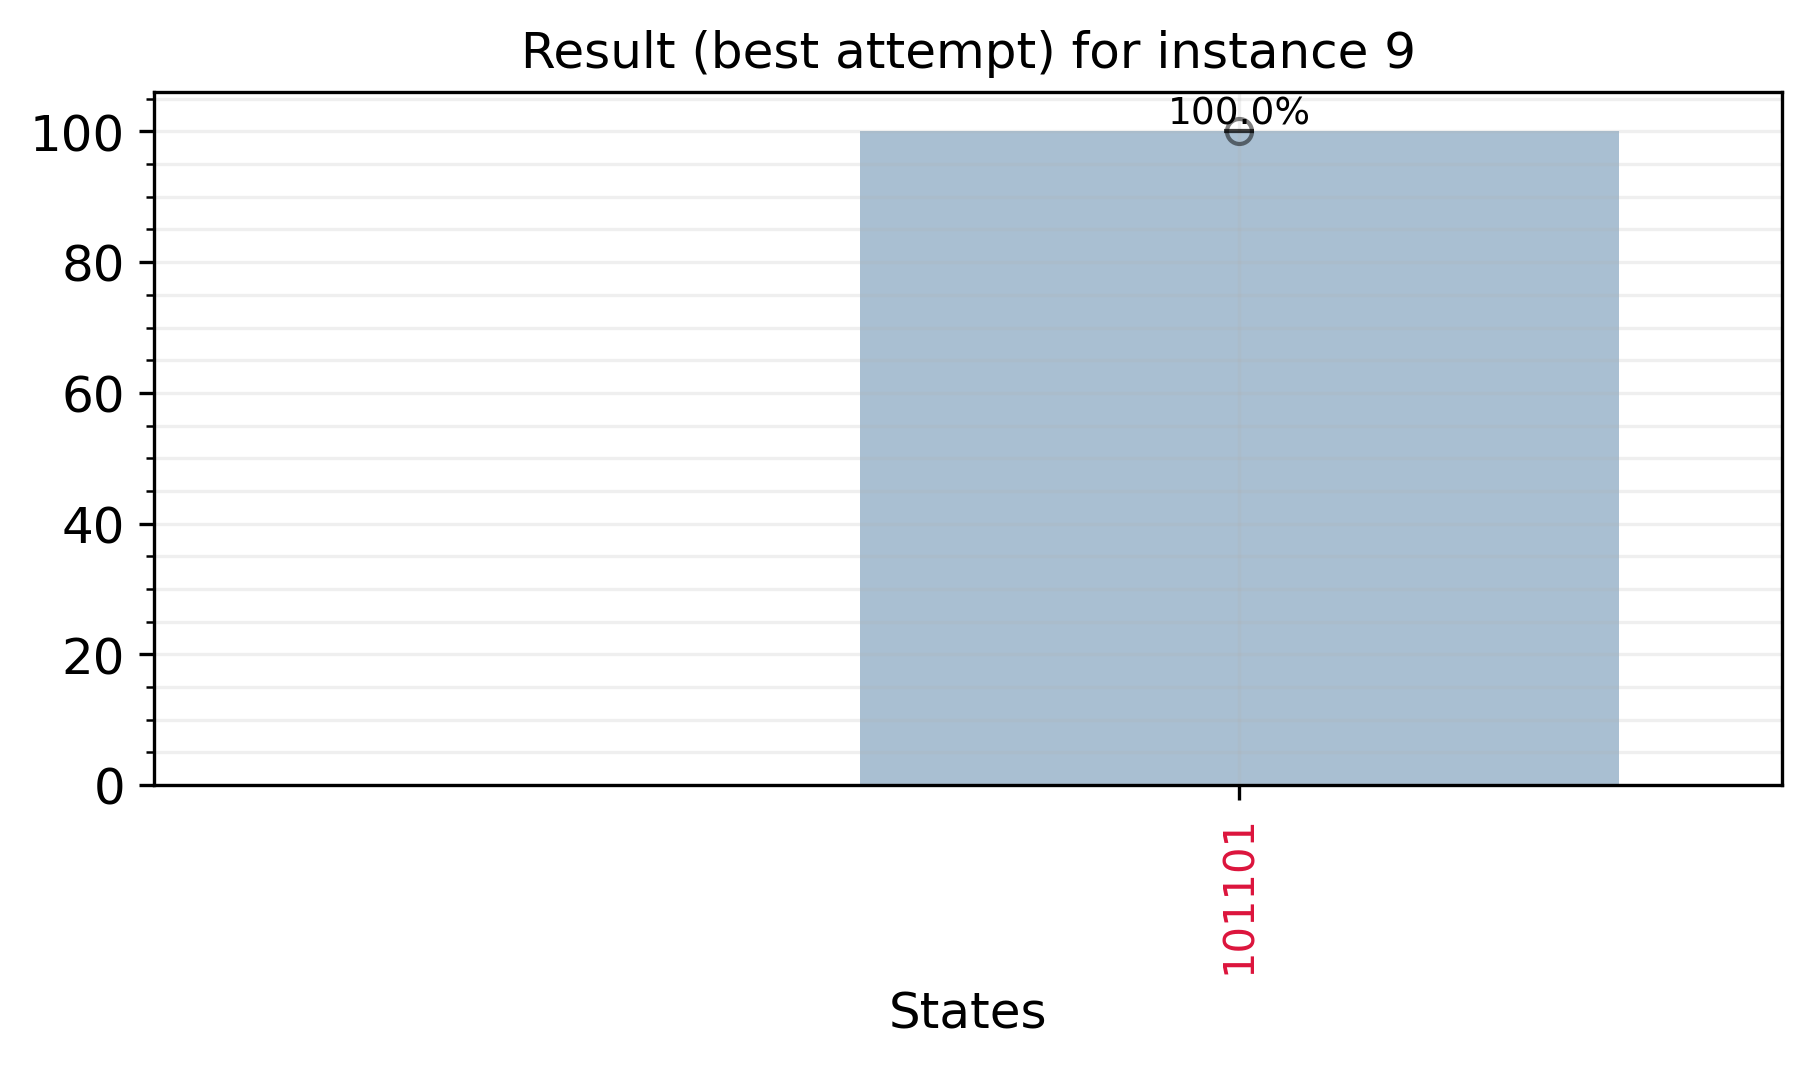

TOTAL_end_time =  1758054308.5700827
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail9_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail9_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt

TOTAL ELAPSED TIME: 9.14818334976832 minutes.
**************************************************
Instance 10 with h = 1.0



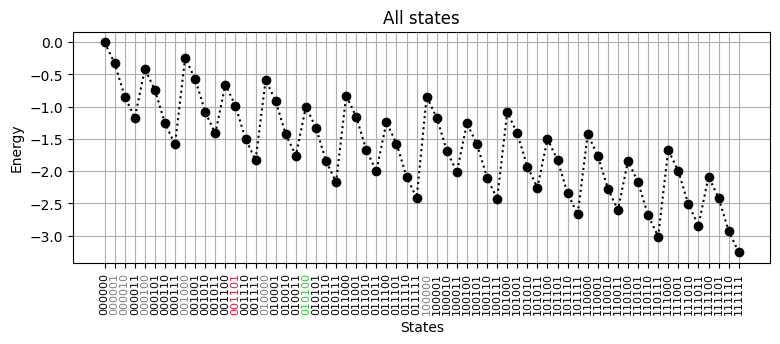

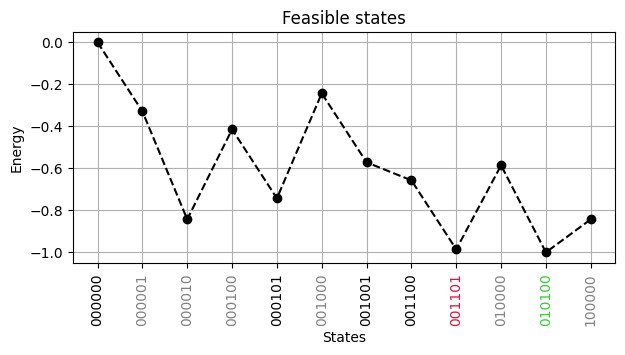

######### ...Writing on file...: #########
Chosen parameters:
Number of layers (p): 3
Number of random attempts: 100
Initialization type: all0
Size (n): 6
Chosen instances (chosen_instances): range(1, 11)
Choice of ks (chosen_ks): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
##########################################
TOTAL_start_time =  1758054308.8620715
---------- 100/100 random_attempts -----------

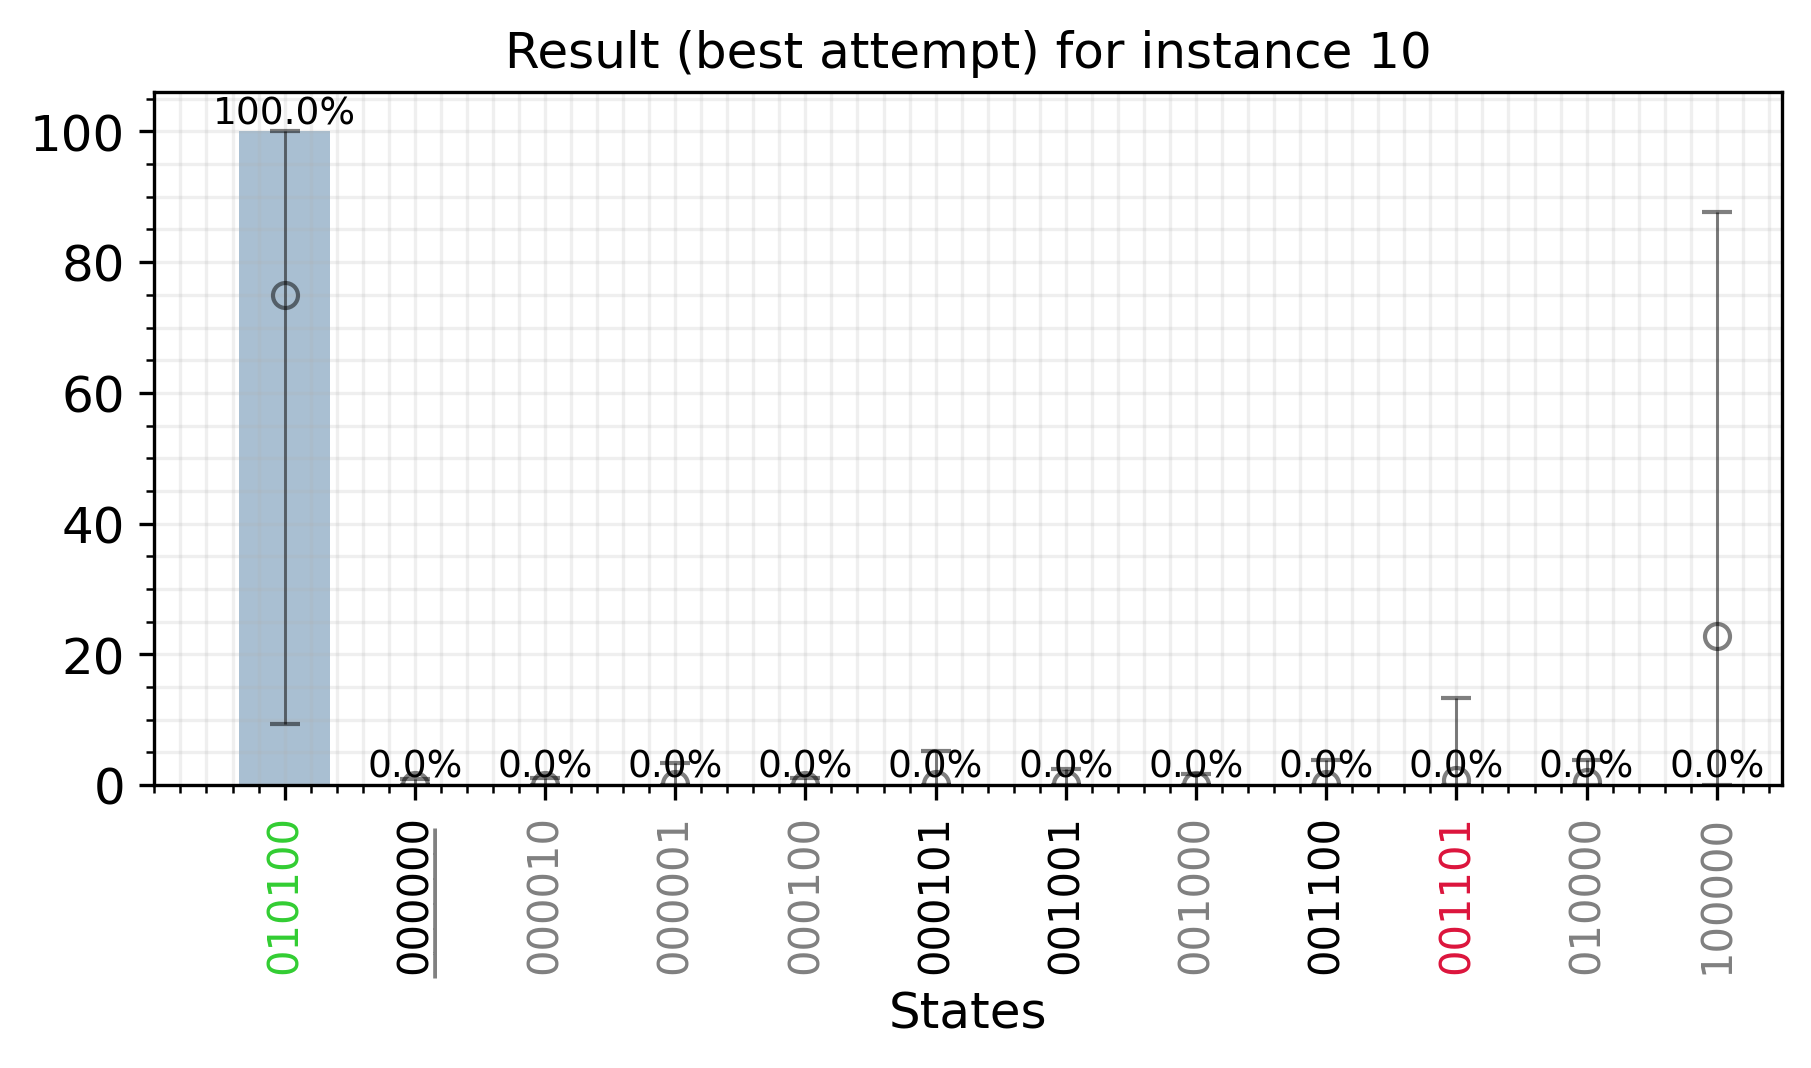

TOTAL_end_time =  1758055197.6417017
Result saved in:
random_parameters_2025-09-16@20h20m11s/dim6_mail10_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781].csv
random_parameters_2025-09-16@20h20m11s/dim6_mail10_all0_random_p3_100ra_k1.0_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781]_data.txt

TOTAL ELAPSED TIME: 14.81299484570821 minutes.


In [7]:
current_datetime = datetime.now().strftime("%Y-%m-%d@%Hh%Mm%Ss")

# Create a  directory where to collect files
folder_path = f"random_parameters_{current_datetime}"
print(f"Saving in folder_path = '{folder_path}'")
os.makedirs(folder_path, exist_ok=True)

# Run QAOA+ for every instance.
for h, instance in zip(chosen_ks, chosen_instances):
    print("*"*50)
    print(f"Instance {instance} with h = {h}\n")

    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing metadata such as energies, betas, gammas.


    # Define the instance.
    U, subsets_dict = define_instance(n, instance, verbose=False)
    subsets = list(subsets_dict.values())
    _, _, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]

    #print("U, subsets, EXACT_COVERS, MEC", U, subsets, EXACT_COVERS, MEC)

    # Plot states vs energy.
    show_spectrum(n, instance, h, fontsize=10)


    # Choose the initialization.
    if init_string == 'all1':
        # Only "1"-states.
        init_name = ["".join(elem) for elem in distinct_permutations('0'*(n-1) + '1')]

    elif init_string == 'all0':
        init_name = ["000000"]


    # Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance,verbose=False)
    qc_initial, check_counts  = build_initialization_circuit(n, instance, init_name, verbose=False)

    # # Check that initialization was correct.
    # plot_histogram(check_counts, ax=plt.subplots()[1], title="Initialization check", color='k')
    # plt.show(block=False) # don't stop execution


    # Set initial angles.
    gamma_bound = find_gamma_bound(n, instance, h, verbose=False)

    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"

    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"


    # Build files' names.
    header = f"dim{n}_mail{instance}_{init_string}" \
           + f"_random_p{p}_{random_attempts}ra_k{h}" \
           + f"_BOUNDS{bnds_string}_pars0{string_0}"

    FILENAME = os.path.join(folder_path, header + f".csv")
    DATA_FILENAME = os.path.join(folder_path, header + f"_data.txt")

    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)


    # Record the details of each attempt in a file.
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        write_params_on_file(DATA_FILE, params) # Write global parameters

        E_best = 100
        TOTAL_start_time = time.time()
        print("TOTAL_start_time = ", TOTAL_start_time)

        for attempt in range(1,random_attempts+1):
            print(f"\r---------- {attempt}/{random_attempts} random_attempts -----------", end="")
            DATA_FILE.write(f"\n---------- {attempt}/{random_attempts} random_attempts -----------\n")

            # Build QAOAAnsatz.
            cost_vs_iteration = [] # to save (and plot) iterations
            ansatz = QAOAAnsatz(qc_cost,
                                mixer_operator=qc_mixing,
                                initial_state=qc_initial,
                                reps=p, name='QAOA+')


            # Generate a pass manager without providing a backend.
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()


            # *************************  FIND OPTIMAL ANGLES  ***************************
            # *************************     THROUGH QAOA+     ***************************

            # Set initial angles and angles'bounds.
            pars_0 = [random.uniform(*beta_0) for _ in range(p)] + \
                     [random.uniform(*gamma_0) for _ in range(p)]
            bnds = [bnds_beta]*p + [bnds_gamma]*p

            # print(f"pars_0 = {pars_0}")
            # print(f"bnds = {bnds}\n")


            # Do the minimization.
            result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations
                              pars_0, bounds=bnds,
                              args=(ansatz_isa, hamiltonian_isa, estimator),
                              method="Nelder-Mead",
                              options={"disp": False, "maxiter": 1200, "maxfev": 1200}, tol=1e-4)


            # Works only if you chose cost_func_plot.
            if cost_vs_iteration != []:
                plt.figure()
                plt.plot(cost_vs_iteration)
                plt.xlabel("Iteration")
                plt.ylabel("Cost")
                plt.show()


            # Minimum energy reached with minimization.
            E_min = result.fun + constant
            # print(f"E_min = result.fun + constant = {E_min}")
            # print(f"E_min = result.fun = {result.fun}")
            DATA_FILE.write(f"\nE_min = {E_min}")


            # Optimal parameters (betas, gammas) found.
            betas = list(result.x[:p])
            gammas = list(result.x[p:])
            # print(f"\nOptimal parameters: betas, gammas = {betas}, {gammas}")
            DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')


            # Update the best attempt.
            if E_min < E_best:
                    E_best = E_min
                    best_attempt = attempt
            #        print("--> ***UPDATING THE BEST ATTEMPT***\n")
            #else:
            #    print("--> ***NOT UPDATING THE BEST ATTEMPT***\n")


            # ****************************  RUN THE CIRCUIT  ******************************
            # ************************ WITH OPTIMAL PARAMETERS ****************************

            # Assign to the previously created ansatz the 2p parameters found.
            pars = betas + gammas
            qc = ansatz.assign_parameters(pars)
            qc.measure_all() # add a measurement

            # Run this circuit.
            qc_isa = pm.run(qc)
            output = sampler.run([qc_isa], shots=1024).result()
            samp_dist = output[0].data.meas.get_counts()


            # ****************************  POST PROCESS  **********************************
            # *********************** AND SAVE THE OUTPUT HISTOGRAM ************************

            # Create a dataframe from the sampling results.
            df = pd.DataFrame(samp_dist.items(), columns=['states', 'counts'])

            # Remove ancillary bits.
            num_ancillas = get_circuit_parameters(subsets, verbose=False)[2]
            df['states'] = df['states'].apply(lambda x: x[num_ancillas:])

            # Invert the bit order for the states (e.g., convert "01101" to "10110").
            df['states'] = df['states'].apply(lambda s: str(s)[::-1])  # Invertiamo l'ordine dei bit

            # After removing the ancillary bits, we aggregate counts by state.
            df = df.groupby(['states']).sum().reset_index()

            # Sort in decreasing order.
            df = df.sort_values('counts', ascending=False)

            # Rename the "counts" column to include attempt details.
            df.columns = ['states', f'counts_p{p}_{attempt}of{random_attempts}']

            # Merge the current attempt dataframe with previously built dataframes.
            if attempt == 1:
                df_all_attempts = df
            else:
                df_all_attempts = pd.merge(df_all_attempts, df, on="states", how="outer")

            # print(df)


        # Save to .csv the global dataframe.
        df_all_attempts.to_csv(FILENAME, index=False)


        # Plot the best attempt (minimum energy), with error bars
        # representing other attempts in the global dataframe.
        plot_histogram_of_best_column(df_all_attempts,
                                      f'counts_p{p}_{best_attempt}of{random_attempts}',
                                      EXACT_COVERS, init_name,
                                      fontsize=12, title=f"Result (best attempt) for instance {instance}")


        DATA_FILE.write("\n*******************************")
        DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{best_attempt} ")

        
        TOTAL_end_time = time.time()
        print("TOTAL_end_time = ", TOTAL_end_time)
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(TOTAL_end_time - TOTAL_start_time)/60} minutes.\n")
        print(f"Result saved in:\n{FILENAME}\n{DATA_FILENAME}")
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")

In [10]:
from IPython.display import Audio, display

# Un piccolo beep (frequenza 440Hz per 0.5 secondi)
import numpy as np

fs = 44100  # sample rate
duration = 0.5  # seconds
f = 440.0  # Hz
samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)

display(Audio(samples, rate=fs, autoplay=True))


## (Optional) Draw the latest instance QAOA circuit

In [ ]:
print(f"Instance #{instance}")
ansatz.decompose(reps=2).draw("mpl")

## Plot from a saved folder ...
### ... for each instance, the best attempt (with also mean and error displayed) or...
Plot the results of all chosen instances for which QAOA has been computed or plot results from a previous run.

The `find_files_containing_string` function will search for `.csv` and `.txt` files in the selected `path`. If provided, it will also search for files that contain a specific string of text.

/home/aurora/Documents/Minimum-Exact-Cover-Problem/MECP_with-QAOA/utils_for_plotting_and_reading.py:235: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  percentage['average'] = percentage.mean(numeric_only=True, axis=1)
/home/aurora/Documents/Minimum-Exact-Cover-Problem/MECP_with-QAOA/utils_for_plotting_and_reading.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  percentage['max'] = percentage.max(numeric_only=True, axis=1)
/home/aurora/Documents/Minimum-Exact-Cover-Problem/MECP_with-QAOA/utils_for_plotting_and_reading.py:237

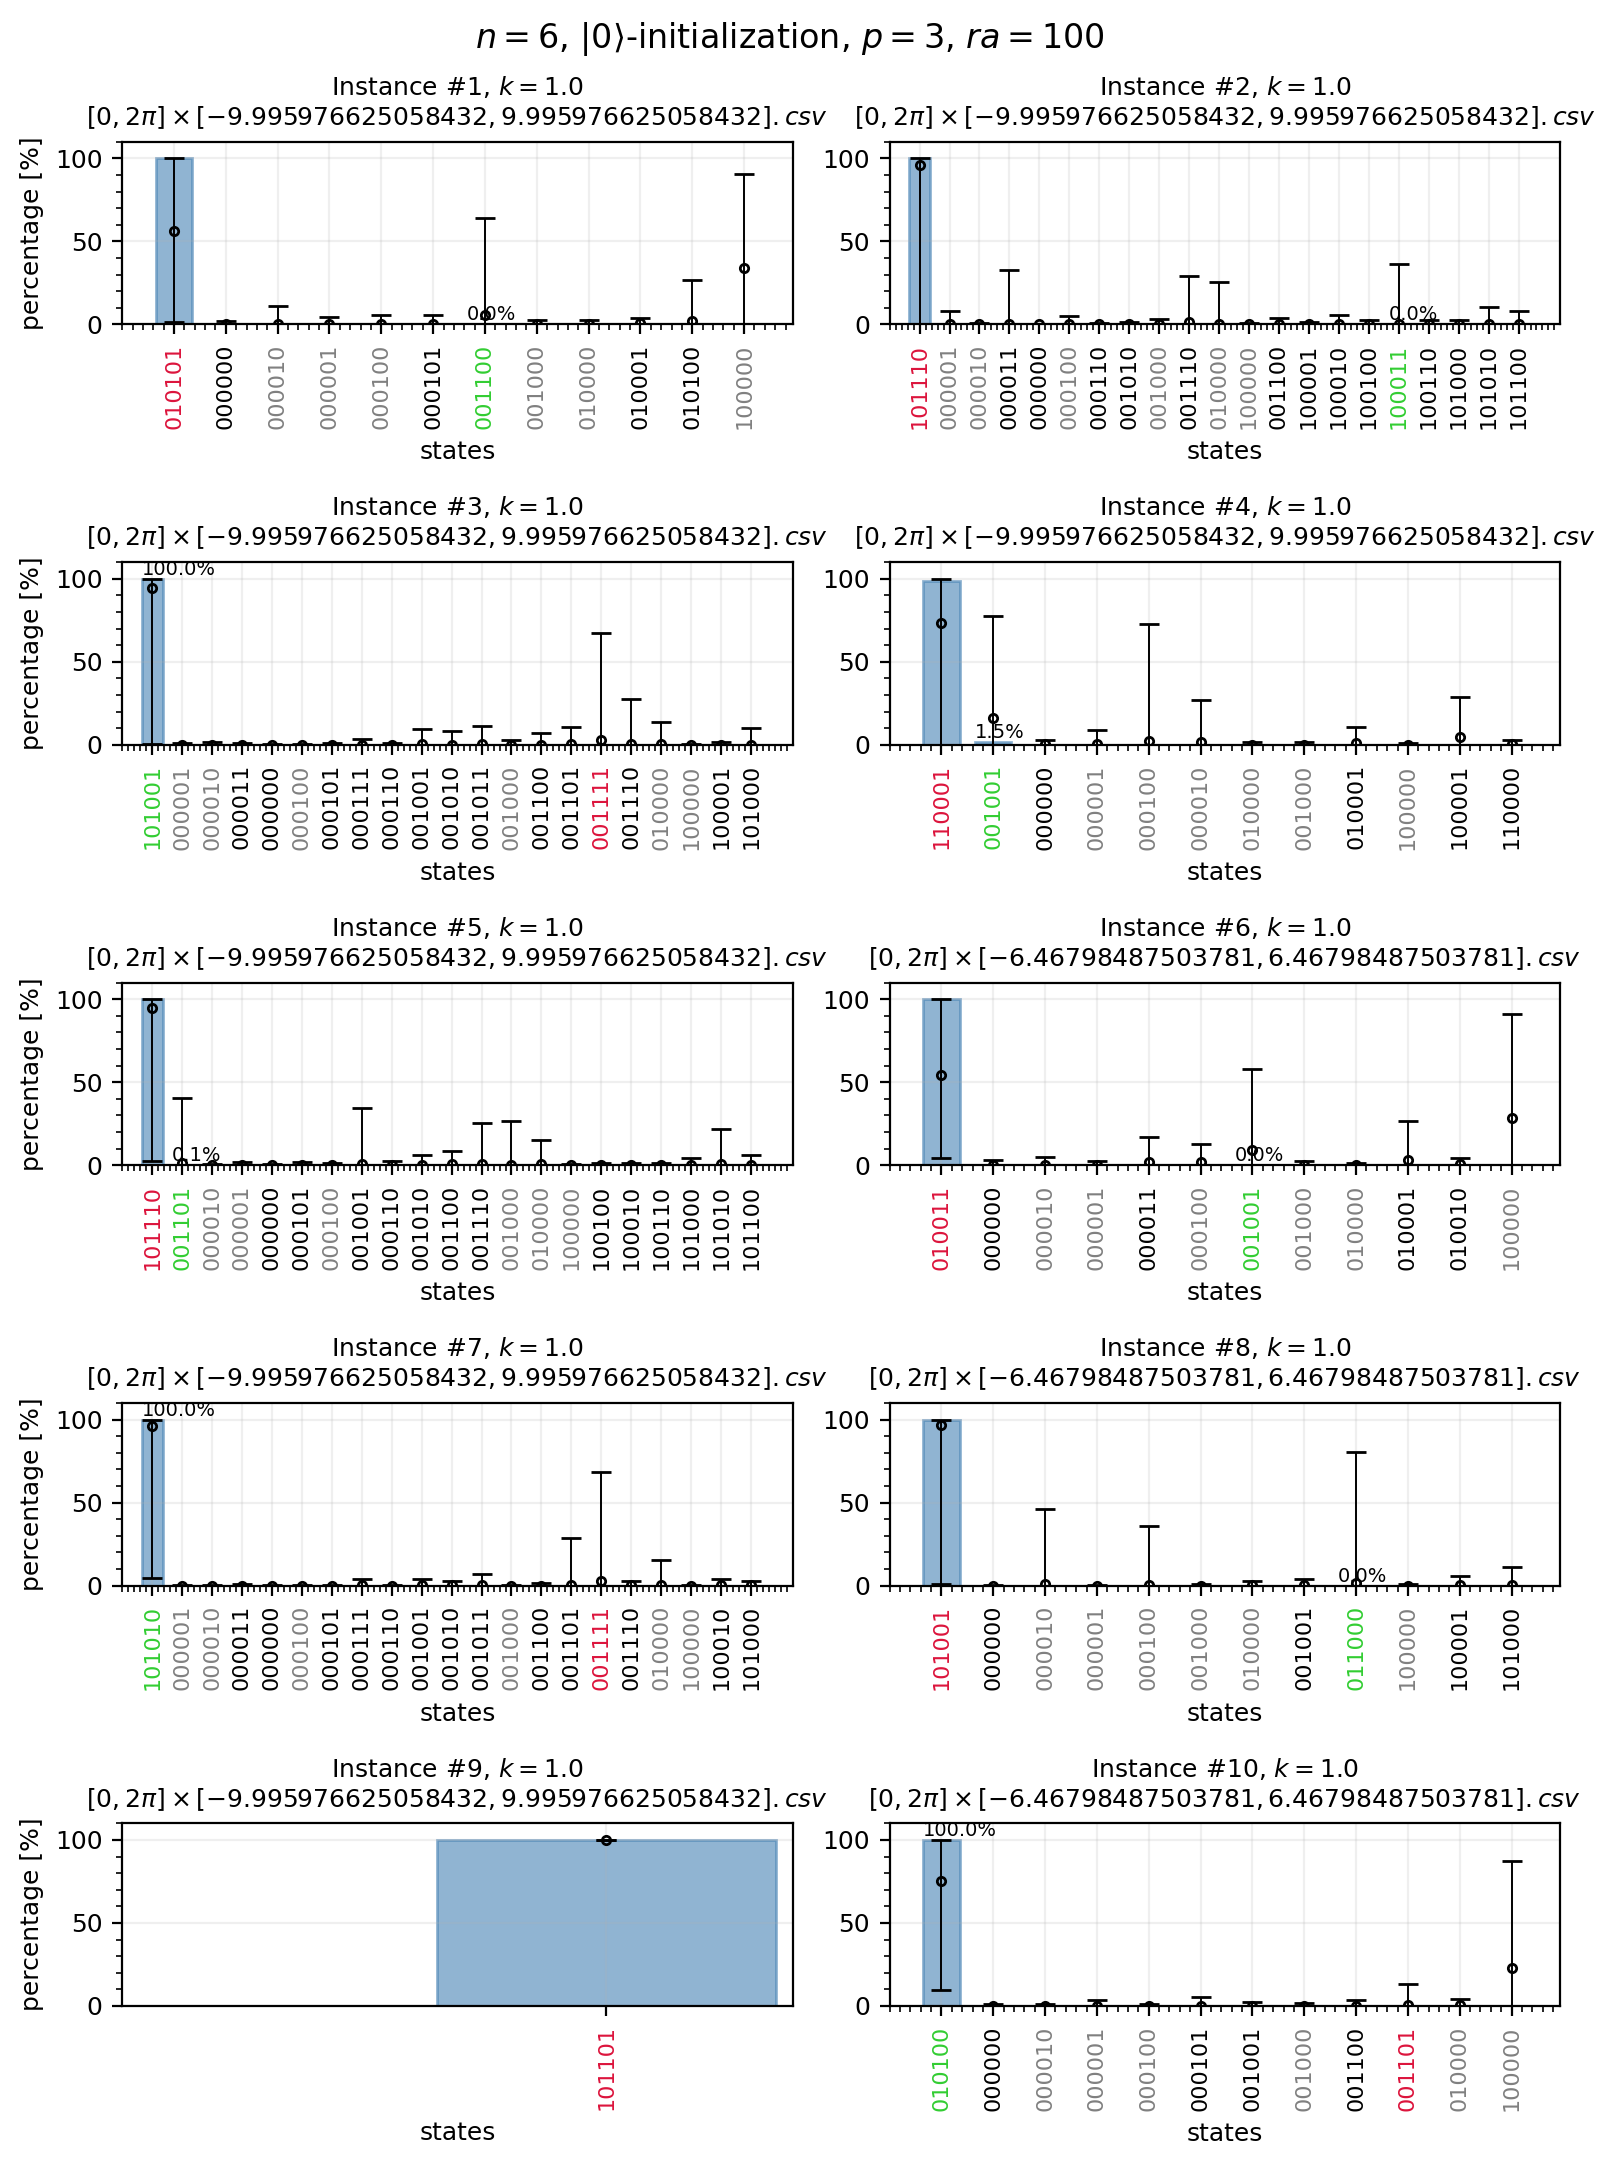

<Figure size 640x480 with 0 Axes>

In [9]:
# Uncomment this line to plot data from an existing directory
# folder_path = "random_parameters_2025-07-21@17h20m50s" # LEC
# folder_path = "random_parameters_2025-07-22@15h10m16s" # LEC-1

# folder_path = "random_parameters_2025-09-08@17h51m29s" # k=1
# folder_path = "random_parameters_2025-09-10@08h23m37s" # L_EC

# Wang instances p=4
# folder_path = "random_parameters_2025-09-13@10h18m50s" # k=1
# folder_path = "random_parameters_2025-09-13@16h32m19s" # L_EC
# folder_path = "random_parameters_2025-09-13@13h11m55s" # L_MEC 


# Find the files that contain every string in 'substrings'.
FILENAME_list, DATA_FILENAME_list = find_files_containing_string(path= f"./{folder_path}/")

# Get the number of files collected.
num_files = len(FILENAME_list)

if num_files>1:
    plot_list_of_files(FILENAME_list, DATA_FILENAME_list,
                       colorchosen="steelblue", alpha=0.6,
                       init_name="all1",
                       dont_show_in_title=["i", "k"],
                       dont_show_in_titles=["n", "p", "ra", "init"],
                       figsize=(8,num_files+1),
                       dpi=200, N=9) # figsize=(10, 13), dpi=300, N=12 for latex figures
else:
    plot_file(FILENAME_list[0], DATA_FILENAME_list[0],
              colorchosen='indigo', alpha=0.4,
              dont_show_in_title = [],
              figsize=(10,4), dpi=200, N=10)

plt.savefig("L_EC-1.png")

### ... for each instance, every single attempt

In [ ]:
# folder_path = "random_parameters_2025-01-30@09h03m50s"
plot_each_attempt_from_folder(folder_path)